In [1]:
import pandas as pd

# 1. Session related features

In [2]:
## load sorted session
tr_sessions = pd.read_csv('./train_sessions_sorted.csv')
print(tr_sessions.columns)

Index(['session_id', 'Unnamed: 1', 'session_id.1', 'item_id', 'date'], dtype='object')


In [5]:
item_feat = pd.read_csv('./item_features.csv')

def get_num_cate(session):
  cnt = 0
  for item in session['item_id'] :
    cnt+=len(item_feat.loc[item_feat['item_id'] == item]['feature_category_id'].unique())
  return cnt

def get_num_val(session):
  cnt = 0
  for item in session['item_id'] :
    cnt+=len(item_feat.loc[item_feat['item_id'] == item]['feature_value_id'].unique())
  return cnt

In [3]:
## cnt clicked times for items, cate, val
tr_sessions = tr_sessions[['session_id', 'item_id', 'date']]
tr_sessions['date'] = pd.to_datetime(tr_sessions['date'], format='%Y-%m-%d %H:%M:%S')
tr_sessions_gb = tr_sessions.groupby(['session_id','item_id'])
cnt_dict = {}


In [ ]:
tr_sessions = tr_sessions[['session_id', 'item_id', 'date']]
tr_sessions['date'] = pd.to_datetime(tr_sessions['date'], format='%Y-%m-%d %H:%M:%S')
tr_sessions_gb = tr_sessions.groupby(['session_id'])

from collections import defaultdict
dic = defaultdict(list)
for gr_name, gr in tr_sessions_gb:
  dic['session_id'].append(gr_name)
  dic['s_year'].append(int(gr.iloc[0,:]['date'].year)) #categorical
  dic['s_month'].append(int(gr.iloc[0,:]['date'].month)) #categorical
  dic['s_day'].append(int(gr.iloc[0,:]['date'].day)) #categorical
  dic['s_hour'].append(int(gr.iloc[0,:]['date'].hour)) #categorical
  dic['s_weekofyear'].append(int(gr.iloc[0,:]['date'].weekofyear))
  dic['s_weekday'].append(int(gr.iloc[0,:]['date'].weekday())) #categorical
  dic['e_year'].append(int(gr.iloc[-1,:]['date'].year)) #categorical
  dic['e_month'].append(int(gr.iloc[-1,:]['date'].month)) #categorical
  dic['e_day'].append(int(gr.iloc[-1,:]['date'].day)) #categorical
  dic['e_hour'].append(int(gr.iloc[-1,:]['date'].hour)) #categorical
  dic['e_weekofyear'].append(int(gr.iloc[-1,:]['date'].weekofyear))
  dic['e_weekday'].append(int(gr.iloc[-1,:]['date'].weekday())) #categorical
  dic['num_clicks'].append(gr.shape[0]) #numerical
  dic['num_items'].append(len(gr['item_id'].unique()))
  dic['num_cate'].append(get_num_cate(gr))
  dic['num_val'].append(get_num_val(gr))
  dic['duration'].append((gr.iloc[-1,:]['date'] - gr.iloc[0,:]['date']).total_seconds()/60)
pd.DataFrame(dic).to_csv('./feat_extract2.csv')

In [5]:
## load feature
X = pd.read_csv('./feat_extract2.csv').iloc[:,1:]
# X = X[["session_id",'year', 'month', 'day', 'hour', 'weekofyear', 'weekday', 'num_clicks', 'duration']]
print(X.shape)
print(X.columns)


(1000000, 18)
Index(['session_id', 's_year', 's_month', 's_day', 's_hour', 's_weekofyear',
       's_weekday', 'e_year', 'e_month', 'e_day', 'e_hour', 'e_weekofyear',
       'e_weekday', 'num_clicks', 'num_items', 'num_cate', 'num_val',
       'duration'],
      dtype='object')


In [ ]:
## reset index for session and item id categorical 

### LGBMRanker

In [6]:
import lightgbm as lgb
gbm = lgb.LGBMRanker(max_depth=20, num_leaves=1024, subsample_for_bin=100000, colsample_bytree=1.0)

In [ ]:


y = pd.read_csv('./train_purchases.csv')
print(X.shape, y.shape)
print(X.columns)
print( y.columns)
li = []
for i, row in X.iterrows():
  label = y.at[i,'item_id']
  # label = y.loc[row['session_id'] == y['session_id']]['item_id']
  li.append(label)
print(li[:10])



In [7]:
# y = pd.DataFrame(li, columns=['item_id'])
# print(y.shape)
# y.to_csv('./feat_extract_y.csv')
y = pd.read_csv('./feat_extract_y.csv')
print(y.columns)
y = y['item_id']

Index(['Unnamed: 0', 'item_id'], dtype='object')


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

query_train = [1000 for _ in range(X_train.shape[0]//1000)]
query_val = [1000 for _ in range(X_val.shape[0]//1000)]
query_test = [1000 for _ in range(X_test.shape[0]//1000)]

In [9]:
import lightgbm as lgb
import numpy as np
label_gain = 2**np.arange(0,28144)
gbm = lgb.LGBMRanker(
  learning_rate=0.05, n_estimators=900, min_child_samples=5, min_child_weight=0.00001, n_jobs=-2,objective='rank_xendcg', label_gain = label_gain
  )

In [10]:
gbm.fit(X_train, y_train, group=query_train,
        eval_set=[(X_val, y_val)], eval_group=[query_val],
        eval_at=[5, 10, 20], early_stopping_rounds=50,
        # categorical_feature=['year','month','day','hour','weekofyear','weekday'],
        verbose=True,
        
        )

/home/seongha/anaconda3/envs/serec/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/seongha/anaconda3/envs/serec/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[2]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[3]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[4]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[5]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[6]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[7]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[8]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[9]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[10]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[11]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[12]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[13]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[14]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[15]	valid_0's ndcg@5: 1	valid_0's ndcg@10: 1	valid_0's ndcg@20: 1
[16]

LGBMRanker(label_gain=array([1, 2, 4, ..., 0, 0, 0]), learning_rate=0.05,
           min_child_samples=5, min_child_weight=1e-05, n_estimators=900,
           n_jobs=-2, objective='rank_xendcg')

In [11]:
test_pred = gbm.predict(X_test)

In [20]:
X_test_cp = X_test
X_test_cp["predicted_ranking"] = test_pred
X_test_cp.sort_values("predicted_ranking", ascending=False)
# X_test_cp[['session_id', 'predicted_ranking']].to_csv('./X_test_cp.csv')

,session_id,s_year,s_month,s_day,s_hour,s_weekofyear,s_weekday,e_year,e_month,e_day,e_hour,e_weekofyear,e_weekday,num_clicks,num_items,num_cate,num_val,duration,predicted_ranking
690760,3067963,2021,1,22,18,3,4,2021,1,22,19,3,4,13,13,279,279,18.123967,2.533749e+18
696122,3091672,2021,2,20,18,7,5,2021,2,20,18,7,5,8,8,155,154,18.419167,2.533749e+18
693917,3082052,2020,11,27,22,48,4,2020,11,27,23,48,4,3,3,66,65,81.510617,2.516776e+18
559216,2482335,2020,9,25,22,39,4,2020,9,25,23,39,4,3,2,64,64,42.919517,2.516776e+18
304737,1355218,2021,2,11,21,6,3,2021,2,11,21,6,3,3,3,54,53,0.488883,1.808039e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750678,3332965,2021,1,9,8,1,5,2021,1,9,8,1,5,6,5,149,149,18.416417,-5.242817e+16
776515,3447814,2021,1,30,9,4,5,2021,1,30,9,4,5,9,6,162,163,18.410283,-5.242817e+16
707075,3140542,2021,1,27,19,4,2,2021,1,27,19,4,2,2,2,36,35,18.327383,-5.242817e+16
919876,4084367,2021,1,29,17,4,4,2021,1,29,17,4,4,6,4,150,150,17.920617,-5.242817e+16


# 2. Item related features

In [4]:
item_feat = pd.read_csv('./item_features.csv')
print(item_feat.columns)
print(item_feat.head())

## item_feat to multi-hot
# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# mlb.fit([item_feat['feature_category_id'].unique()])
# mlb.classes_
# item_feat.groupby(['item_id'])

Index(['item_id', 'feature_category_id', 'feature_value_id'], dtype='object')
   item_id  feature_category_id  feature_value_id
0        2                   56               365
1        2                   62               801
2        2                   68               351
3        2                   33               802
4        2                   72                75


In [3]:
print(tr_sessions.columns)
print(item_feat.columns)


Index(['session_id', 'Unnamed: 1', 'session_id.1', 'item_id', 'date'], dtype='object')


NameError: name 'item_feat' is not defined

### EDA

In [23]:
print(len(item_feat['feature_category_id'].unique()),  min(item_feat['feature_category_id'].unique()), max(item_feat['feature_category_id'].unique()))
print(len(item_feat['feature_value_id'].unique()), min(item_feat['feature_value_id'].unique()), max(item_feat['feature_value_id'].unique()))
print('Number of NAN values:', item_feat['feature_category_id'].isna().sum())
print('Number of NAN values:', item_feat['feature_value_id'].isna().sum())

73 1 73
890 1 905
Number of NAN values: 0
Number of NAN values: 0


In [13]:
## find correlation - Cramer's V statistics, Uncertainty Coeffcient
## source: https://www.kaggle.com/code/vadbeg/pytorch-nn-with-embeddings-and-catboost/notebook

from scipy.stats import chi2_contingency, entropy
from collections import Counter
import numpy as np

def cramers_v(x, y):
    """
        Calculates Cramer's V statistic for categorical-categorical association.
        
        :param x: pd.Series or np.array
        :param y: pd.Series or np.array 
        
        :return: Cramer's V statistic, float in range of [0, 1]
    """
    
    confusion_matrix = pd.crosstab(x, y)
    
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    n = confusion_matrix.sum().sum()
    
    r, k = confusion_matrix.shape
    phi_2 = chi2 / n
    
    phi2corr = max(0, phi_2 - ((k - 1) * (r - 1)) / (n - 1))
    
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    
    res = np.sqrt(phi2corr / min(kcorr - 1, rcorr - 1))
    
    return res

def conditional_entropy(x, y):
    """
        Calculates the conditional entropy of x given y: S(x|y)
    
        :param x: pd.Series or np.array
        :param y: pd.Series or np.array 
        
        :return: float
    """
    
    y_counter = Counter(y)
    xy_counter = Counter((list(zip(x, y))))
    
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        
        entropy += p_xy * np.log(p_y / p_xy)
        
    return entropy

def theils_u(x, y):
    """
        Calculates Theil's U statistic (Uncertainty coefficient) for categorical-categorical association.
    
        :param x: pd.Series or np.array
        :param y: pd.Series or np.array 
        
        :return: Theil's U statistic, float in range of [0, 1]
    """
    
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    
    total_occurrences = sum(x_counter.values())
    
    p_x = list(map(lambda n: n / total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    
    if s_x == 0:
        return 1
    
    else:
        return (s_x - s_xy) / s_x
        


In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


<AxesSubplot:title={'center':'Cramers V'}>

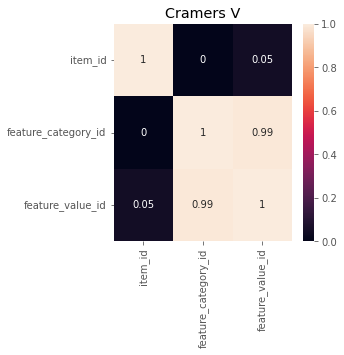

In [23]:

plt.rcParams.update({'font.size': 10})

plt.subplots(figsize=(4, 4))
plt.title('Cramers V')

corr_res = round(item_feat.corr(method=cramers_v), 2)
sns.heatmap(corr_res, annot=True)



<AxesSubplot:title={'center':'Pearson'}>

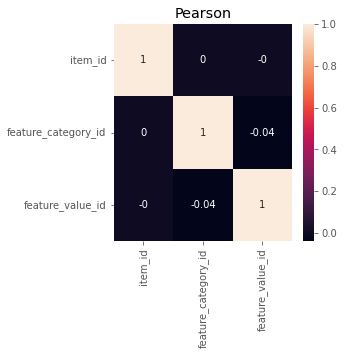

In [19]:
plt.subplots(figsize=(4, 4))
plt.title('Pearson')


corr_simple_res = round(item_feat.corr(), 2)
sns.heatmap(corr_simple_res, annot=True)

In [26]:
X = pd.read_csv('./feat_extract.csv')
print(X.columns)
pivot_mean = pd.pivot_table(X, index=['item_first_clicked'], columns = ['item_first_clicked'], values=['hour'])

Index(['Unnamed: 0', 'session_id', 'item_first_clicked', 'year', 'month',
       'day', 'hour', 'weekofyear', 'weekday', 'num_clicks', 'duration'],
      dtype='object')


ValueError: Grouper for 'item_first_clicked' not 1-dimensional